In [74]:
import os
import pandas as pd
import torch

from learning_models.sidarthe import Sidarthe
from learning_models.tied_sidarthe_extended import TiedSidartheExtended
from populations import populations

from utils.data_utils import select_data
from utils.visualization_utils import generic_plot, Curve, generic_sub_plot, Plot, generate_format_xtick

from torch_euler import Heun
import json

import seaborn as sns
import datetime

from utils.visualization_utils import parse_date

In [75]:
experiments_path = os.path.join(os.getcwd(), "runs", "sliding_train_exps_a0.0", "sidarthe_extended", "Italy")
figs_path = os.path.join(experiments_path, "figs") 
if not os.path.exists(figs_path):
    os.makedirs(figs_path)
experiments = list_experiments_in_dir(experiments_path)


In [76]:
# load targets

# load targets
# df_file = os.path.join(os.getcwd(), "data", "COVID-19", "dati-andamento-nazionale", "dpc-covid19-ita-andamento-nazionale.csv")
df_file = os.path.join(os.getcwd(), "data", "dati-fr", "fr_data_processed.csv")
area = ["FR"]
area_col_name = "stato"  # "Country/Region"

groupby_cols = ["data"]  # ["Date"]

d_col_name = "isolamento_domiciliare"
r_col_name = "ricoverati_con_sintomi"
t_col_name = "terapia_intensiva"
h_detected_col_name = "dimessi_guariti"
e_col_name = "deceduti"  # "Fatalities"

x_target, d_target, dates = select_data(df_file, area, area_col_name, d_col_name, groupby_cols, file_sep=",")
_, y_target, _ = select_data(df_file, area, area_col_name, "totale_positivi", groupby_cols, file_sep=",")
_, r_target, _ = select_data(df_file, area, area_col_name, r_col_name, groupby_cols, file_sep=",")
_, t_target, _ = select_data(df_file, area, area_col_name, t_col_name, groupby_cols, file_sep=",")
_, h_detected_target, _ = select_data(df_file, area, area_col_name, h_detected_col_name, groupby_cols, file_sep=",")
_, e_target, _ = select_data(df_file, area, area_col_name, e_col_name, groupby_cols, file_sep=",")

#print(len(dates))
#print(dates)
initial_len = len(y_target)
tmp_d, tmp_r, tmp_t, tmp_h, tmp_e = [], [], [], [], []
for i in range(initial_len):
    # if y_target[i] > 0:
    if d_target[i] + r_target[i] > 0:
        tmp_d = d_target[i:]
        tmp_r = r_target[i:]
        tmp_t = t_target[i:]
        tmp_h = h_detected_target[i:]
        tmp_e = e_target[i:]
        first_date = dates[i]
        dates_x = dates[i:]
        break

d_target = tmp_d
r_target = tmp_r
t_target = tmp_t
h_detected_target = tmp_h
e_target = tmp_e

targets = {
    "d": d_target,
    "r": r_target,
    "t": t_target,
    "h_detected": h_detected_target,
    "e": e_target
}
x_target = x_target[-len(targets["d"]):]


In [77]:
# load references
references = {}
param_keys = ['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'theta', 'xi', 'eta', 'mu', 'nu', 'tau', 'lambda', 'kappa', 'zeta', 'rho', 'sigma']
ref_df = pd.read_csv(os.path.join(os.getcwd(), "data", "sidarthe_results_new.csv"))
#ref2_df = pd.read_csv(os.path.join(os.getcwd(), "regioni", "sidarthe_results_2.csv"))


for key in 'sidarthe':
    references[key] = ref_df[key][4:].tolist()

for key in ["h_detected"]:
    references[key] = ref_df[key][4:].tolist()

for key in ["r0"]:
    references[key] = ref_df[key][4:].tolist()

for key in param_keys:
    references[key] = ref_df[key][4:].tolist()


In [78]:
# create models

models = {}

for exp in experiments:
    exp_report = exp['final']
    exp_settings = exp['settings']
    population = populations["Italy"]
    integrator = Heun
    time_step = 1.

    params = exp_report["params"]
    train_size = exp_settings["train_size"]
    val_size = exp_settings["val_len"]
    dataset_size = len(x_target)

    model_params = { 
        "d_weight": 1.,
        "r_weight": 1.,
        "t_weight": 1.,
        "h_weight": 1.,
        "e_weight": 1.,
        "der_1st_reg": 0.,
        "bound_reg": 0.,
        "verbose": False,
        "loss_type": "rmse",
        "references": references,
        "targets": targets,
        "train_size": train_size,
        "val_size": val_size,
        "first_date": dates[0]
    }
    init_conditions_params = { "population": population }
    initial_conditions = Sidarthe.compute_initial_conditions_from_targets(targets, init_conditions_params)

    model = TiedSidartheExtended(params, population, initial_conditions, integrator, time_step, **model_params)
    models[train_size] = model


{'d': 5.39547419814073, 'r': 14.128906233440867, 't': 82.4371125311178, 'h': 1.0, 'e': 6.037797696651292}
{'d': 5.39547419814073, 'r': 14.128906233440867, 't': 82.4371125311178, 'h': 1.0, 'e': 6.037797696651292}
{'d': 5.39547419814073, 'r': 14.128906233440867, 't': 82.4371125311178, 'h': 1.0, 'e': 6.037797696651292}
{'d': 5.39547419814073, 'r': 14.128906233440867, 't': 82.4371125311178, 'h': 1.0, 'e': 6.037797696651292}
{'d': 5.39547419814073, 'r': 14.128906233440867, 't': 82.4371125311178, 'h': 1.0, 'e': 6.037797696651292}
{'d': 5.39547419814073, 'r': 14.128906233440867, 't': 82.4371125311178, 'h': 1.0, 'e': 6.037797696651292}
{'d': 5.39547419814073, 'r': 14.128906233440867, 't': 82.4371125311178, 'h': 1.0, 'e': 6.037797696651292}
{'d': 5.39547419814073, 'r': 14.128906233440867, 't': 82.4371125311178, 'h': 1.0, 'e': 6.037797696651292}
{'d': 5.39547419814073, 'r': 14.128906233440867, 't': 82.4371125311178, 'h': 1.0, 'e': 6.037797696651292}


In [102]:
data = []
indexes = []

dataset_size = len(x_target)

for exp in experiments: 
    try: # avoid NaNs
        val_loss = exp['final']['val_risks']['nrmse']
    except:
        val_loss = np.nan

    tsize = exp['settings']['train_size']

    model = models[tsize]

    t_grid = torch.linspace(0, dataset_size, dataset_size+1)
    inferences = model.inference(t_grid)
    
    for idx, val in enumerate(inferences['r0']):
        start_date = parse_date(model.first_date)

        date = pd.to_datetime( (start_date + datetime.timedelta(int(idx))).strftime("%Y-%m-%d"))
        data.append({
            'date': date,
            'r0': val.item()
        })
        indexes.append((tsize,idx))


index = pd.MultiIndex.from_tuples(indexes, names=['tsize','t'])
df = pd.DataFrame(data, index=index)
# df

In [103]:
tsize_index = index.unique('tsize').sort_values()
t_index = index.unique('t')
tsize_index

Int64Index([68, 83, 98, 113, 128, 143, 158, 173, 188], dtype='int64', name='tsize')

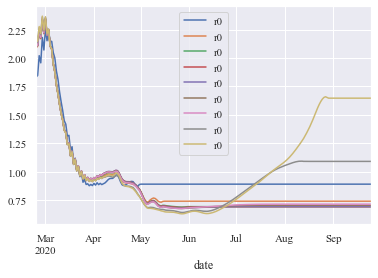

In [116]:
pl, ax = plt.subplots()
for tsize in tsize_index:
    df_r0 = df.loc[tsize]
    df_r0.reset_index(drop=True,inplace=True)
    df_r0.set_index('date', inplace=True)
    df_r0.rename({'r0': str(tsize)})
    #plot = sns.lineplot(data=df_r0, x='date', ax=ax, y='r0', label=f"{tsize}", legend='brief')
    df_r0.plot(ax=ax)
    print(plot.xaxis.get_major_formatter())



figure = plot.get_figure()
figure.set_size_inches((5,3.5))
figure.set_tight_layout(True)
figure.savefig(os.path.join(figs_path, "r0_varying_tsize.pdf"))